# Investigating Spey fitting of a histogram from Contur

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import spey
spey.set_log_level(3) # debug

# load some data from a contur histogram
bg = np.array([3.612882e-03, 1.598201e-03, 3.186370e-05])
meas = np.array([3.2194e-03, 1.4437e-03, 3.0542e-05])
signal = np.array([1.26975467e-06, 0.00000000e+00, 0.00000000e+00])
measurement_cov = np.array([[1.25297487e-07, 3.41845046e-08, 1.09669171e-09],[3.41845046e-08, 1.19312634e-08, 3.20895254e-10],[1.09669171e-09, 3.20895254e-10, 1.88543549e-11]])
background_cov = np.array([[4.37507776e-08, 0.00000000e+00, 0.00000000e+00], [0.00000000e+00, 4.15880810e-09, 0.00000000e+00],[0.00000000e+00, 0.00000000e+00, 5.55546207e-13]])
signal_cov = np.array([[1.72952086e-12, 0.00000000e+00, 0.00000000e+00],[0.00000000e+00, 8.52595599e-15, 0.00000000e+00],[0.00000000e+00, 0.00000000e+00, 6.63785501e-17]])

## Recreate the calculation currently implemented in Contur

In [2]:
from scipy.stats import norm

inv_cov_s_b = np.linalg.inv(signal_cov+measurement_cov+background_cov)
inv_cov_b_only = np.linalg.inv(measurement_cov+background_cov)

# contstruct a chi_square test statistic in the asymptotic limit
delta_mu_test = signal + bg - meas
delta_mu_null = bg - meas
ts_s_b = np.dot(delta_mu_test,np.dot(inv_cov_s_b,delta_mu_test))
ts_b = np.dot(delta_mu_null,np.dot(inv_cov_s_b,delta_mu_null))

# the test statistics are chi-sq distributed, so calculate the log(p-value)
log_pval_sb, log_pval_b = norm.logsf(np.sqrt((ts_s_b,ts_b)))

# convert to CLs value
CLs = 1 - np.exp(log_pval_sb - log_pval_b)
print(f'Current Contur CLs: {CLs}')

Current Contur CLs: 0.002476747131786694


## Spey CLs Calculation

In [3]:
# build the contur plugin
contur_model = spey.get_backend("contur.full_histogram_likelihood")(
    signal_yields=signal,
    background_yields=bg,
    data=meas,
    signal_covariance=signal_cov,
    background_covariance=background_cov,
    data_covariance=measurement_cov
)

Spey - DEBUG (likelihoods.__init__() in likelihoods.py::L130): Min POI set to : -2845.3386196248443


In [4]:
# build some default spey models for comparison
corr_bkd = spey.get_backend('default_pdf.correlated_background')(
    signal_yields=signal,
    background_yields=bg,
    data=meas,
    covariance_matrix=background_cov,
)

uncorr_bkd = spey.get_backend('default_pdf.uncorrelated_background')(signal_yields=signal,
                              background_yields=bg,
                              data=meas,
                              absolute_uncertainties=np.sqrt(np.diag(background_cov))
)

multinorm = spey.get_backend('default_pdf.multivariate_normal')(signal_yields=signal,
                              background_yields=bg,
                              data=meas,
                              covariance_matrix=signal_cov+background_cov+measurement_cov
)

Spey - DEBUG (__init__.__init__() in __init__.py::L108): Min POI set to : -2845.3386196248443
Spey - DEBUG (distributions.__init__() in distributions.py::L264): Adding constraint terms:
Spey - DEBUG (distributions.__init__() in distributions.py::L270): {'distribution_type': 'multivariatenormal', 'args': [array([0., 0., 0.]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])], 'kwargs': {'domain': slice(1, None, None)}}
Spey - DEBUG (__init__.__init__() in __init__.py::L108): Min POI set to : -2845.3386196248443
Spey - DEBUG (distributions.__init__() in distributions.py::L264): Adding constraint terms:
Spey - DEBUG (distributions.__init__() in distributions.py::L270): {'distribution_type': 'normal', 'args': [array([0., 0., 0.]), array([1., 1., 1.])], 'kwargs': {'domain': slice(1, 4, None)}}


### CLs computation for each model

All models give a CLs of 1.0 when the asymptotic calculator is used

The three models involving Poisson terms give a very low CLs value when the chi-squared calculator is used

Could this be because the Poisson terms expect yields larger than one?

In [5]:
models = [contur_model,corr_bkd,uncorr_bkd,multinorm]
spey.set_log_level(2)
for model in models:
    print(model._backend.name,', asymptotic calculator, CLs: ' ,model.exclusion_confidence_level(calculator='asymptotic')[0])
    print(model._backend.name,', chi_square calculator, CLs: ' ,model.exclusion_confidence_level(calculator='chi_square')[0])

Spey - ERROR: Asimov test statistic is zero. Note: Asimov test statistic of zero indicates a lack of evidence for a signal or deviation from a null hypothesis.
contur.full_histogram_likelihood , asymptotic calculator, CLs:  0.0
contur.full_histogram_likelihood , chi_square calculator, CLs:  4.34573568908192e-07
Spey - ERROR: Asimov test statistic is zero. Note: Asimov test statistic of zero indicates a lack of evidence for a signal or deviation from a null hypothesis.
default_pdf.correlated_background , asymptotic calculator, CLs:  0.0
default_pdf.correlated_background , chi_square calculator, CLs:  1.8723454231484027e-07
Spey - ERROR: Asimov test statistic is zero. Note: Asimov test statistic of zero indicates a lack of evidence for a signal or deviation from a null hypothesis.
default_pdf.uncorrelated_background , asymptotic calculator, CLs:  0.0
default_pdf.uncorrelated_background , chi_square calculator, CLs:  1.8723454231484027e-07
Spey - ERROR: Asimov test statistic is zero. Note

### Chi-squared calculator

**Conclusion:** For the models that have a Poisson term dependence, the optimiser isn't minimising the NLL very well, resulting in a weaker CLs value

From `spey.base.hypotest_base.HypothesisTestingBase`:

If `poi_test_denominator=None` computes

$$\chi^2 = -2\log\left(\frac{\mathcal{L}(\mu,\theta_\mu)}{\mathcal{L}(\hat\mu,\hat\theta)}\right)$$

else

$$\chi^2 = -2\log\left(\frac{\mathcal{L}(\mu,\theta_\mu)}{\mathcal{L}(\mu_{\rm denom},\theta_{\mu_{\rm denom}})}\right)$$

So what happens with no minimization of the NLL?

In [6]:
# look at multivariate normal model first as that seems to give sensible results
# the poi that minimises the NLL is very close to 0, so these methods give the same results
spey.set_log_level(3)
print(f"without NLL minimization, CLs: {multinorm.exclusion_confidence_level(poi_test=1.0,poi_test_denominator=0.0,calculator='chi_square')}")
print(f"with NLL minimization, CLs: {multinorm.exclusion_confidence_level(calculator='chi_square')}")


Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [1.11022302e-16]
without NLL minimization, CLs: [0.04752545074571424]
Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [1.11022302e-16]
with NLL minimization, CLs: [0.04752545074571424]


/Users/joeegan/Documents/phd/code/spey_contur_plugin/spey_venv/lib/python3.11/site-packages/spey/optimizer/scipy_tools.py:58: OptimizeWarning: Unknown solver options: poi_test_denominator
  opt = scipy.optimize.minimize(


In [7]:
# now try the uncorrelated background model
# this time, the poi that minimises the NLL is close to 1.0
spey.set_log_level(3)
print(f"without NLL minimization, CLs: {uncorr_bkd.exclusion_confidence_level(poi_test_denominator=0.0,calculator='chi_square')}")
print(f"with NLL minimization, CLs: {uncorr_bkd.exclusion_confidence_level(calculator='chi_square')}")

Spey - DEBUG (__init__.get_objective_function() in __init__.py::L256): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (__init__.get_logpdf_func() in __init__.py::L301): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [ 9.99999799e-01 -3.30392984e-05 -8.49370420e-06 -4.72468515e-08]
Spey - DEBUG (__init__.get_objective_function() in __init__.py::L256): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (__init__.get_logpdf_func() in __init__.py::L301): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 1.0
Spey - DEBUG (__init__.get_objective_function() in __init__.py::L256): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (__init__.get_logpdf_func() in __init__.py::L301): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 0.0
without NLL minimizatio

/Users/joeegan/Documents/phd/code/spey_contur_plugin/spey_venv/lib/python3.11/site-packages/spey/optimizer/scipy_tools.py:58: OptimizeWarning: Unknown solver options: poi_test_denominator
  opt = scipy.optimize.minimize(
/Users/joeegan/Documents/phd/code/spey_contur_plugin/spey_venv/lib/python3.11/site-packages/spey/optimizer/scipy_tools.py:58: OptimizeWarning: Unknown solver options: poi_test_denominator
  opt = scipy.optimize.minimize(
/Users/joeegan/Documents/phd/code/spey_contur_plugin/spey_venv/lib/python3.11/site-packages/spey/optimizer/scipy_tools.py:58: OptimizeWarning: Unknown solver options: poi_test_denominator
  opt = scipy.optimize.minimize(


In [8]:
# now try the contur one
# again the limit gets weaker when we try to do the NLL minimisation, so something is going wrong with the minimisation procedure
# also the value it finds is very close to the uncorrelated background case, suggesting that these Poisson based likelihoods are struggling to minimise the NLL
spey.set_log_level(3)
print(f"without NLL minimization, CLs: {contur_model.exclusion_confidence_level(poi_test_denominator=0.0,calculator='chi_square')}")
print(f"with NLL minimization, CLs: {contur_model.exclusion_confidence_level(calculator='chi_square')}")

Spey - DEBUG (likelihoods.get_objective_function() in likelihoods.py::L283): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (likelihoods.get_logpdf_func() in likelihoods.py::L328): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [ 9.99998931e-01 -1.04710129e-05  7.20397632e-04  8.69815210e-05
 -1.51042406e-05 -2.13116771e-05  9.48866691e-05 -1.50121501e-05
 -7.48477581e-06  1.31296034e-06]
Spey - DEBUG (likelihoods.get_objective_function() in likelihoods.py::L283): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (likelihoods.get_logpdf_func() in likelihoods.py::L328): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 1.0
Spey - DEBUG (likelihoods.get_objective_function() in likelihoods.py::L283): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (likelihoods.get_logpdf_func() in likelihoods.py::L328): Data: [3.

/Users/joeegan/Documents/phd/code/spey_contur_plugin/spey_venv/lib/python3.11/site-packages/spey/optimizer/scipy_tools.py:58: OptimizeWarning: Unknown solver options: poi_test_denominator
  opt = scipy.optimize.minimize(
/Users/joeegan/Documents/phd/code/spey_contur_plugin/spey_venv/lib/python3.11/site-packages/spey/optimizer/scipy_tools.py:58: OptimizeWarning: Unknown solver options: poi_test_denominator
  opt = scipy.optimize.minimize(
/Users/joeegan/Documents/phd/code/spey_contur_plugin/spey_venv/lib/python3.11/site-packages/spey/optimizer/scipy_tools.py:58: OptimizeWarning: Unknown solver options: poi_test_denominator
  opt = scipy.optimize.minimize(


with NLL minimization, CLs: [4.34573568908192e-07]


### See how the likelihoods with Poisson terms perform when we set the initial poi guess to zero

*Conclusion:* They return a comparable exclusion to the multivariate normal model result

Q. the minimisation of NLL is not dependent on which calculator is used (right?)

From the log outputs, the poi is fit to a very small value ~1e-23 when `statistical_model.maximize_likelihood()` is called

Q. So why in `core.fit()` is the POI fixed to 1.0? 

In [9]:
init_pars=[0.,1.,1.,1.]
corr_bkd.exclusion_confidence_level(calculator='chi_square',init_pars=init_pars,do_grad=True)


Spey - DEBUG (__init__.get_objective_function() in __init__.py::L256): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (__init__.get_logpdf_func() in __init__.py::L301): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [ 5.29395592e-23 -3.29807856e-05 -8.49370420e-06 -4.72468513e-08]
Spey - DEBUG (__init__.get_objective_function() in __init__.py::L256): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (__init__.get_logpdf_func() in __init__.py::L301): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 1.0
Spey - DEBUG (__init__.get_objective_function() in __init__.py::L256): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (__init__.get_logpdf_func() in __init__.py::L301): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 0.0


[0.00041982547747398957]

In [10]:
contur_model.exclusion_confidence_level(calculator='chi_square',init_pars=list(np.append(0.0,np.ones(9))),do_grad=True)

Spey - DEBUG (likelihoods.get_objective_function() in likelihoods.py::L283): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (likelihoods.get_logpdf_func() in likelihoods.py::L328): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [ 7.16545206e-23 -1.04700452e-05  7.20469080e-04  8.70374458e-05
 -1.51037188e-05 -2.13111555e-05  9.49326182e-05 -1.50117728e-05
 -7.49748002e-06  1.31514037e-06]
Spey - DEBUG (likelihoods.get_objective_function() in likelihoods.py::L283): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (likelihoods.get_logpdf_func() in likelihoods.py::L328): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 1.0
Spey - DEBUG (likelihoods.get_objective_function() in likelihoods.py::L283): Data: [3.2194e-03 1.4437e-03 3.0542e-05]
Spey - DEBUG (likelihoods.get_logpdf_func() in likelihoods.py::L328): Data: [3.

[0.0004198149087206726]

### Asymptotic calculator

Q. Why is the limit 1.0 for all the models when this calculator is used?

Setting the initial POI to zero, we get something more sensible

Q. The initial parameter value is set to the user inputted value each time `core.fit()` is called, rather than using the `fit parameters` value returned by `statistical_model.maximize_likelihood()`, is this supposed to happen?

In [11]:
multinorm.exclusion_confidence_level(calculator='asymptotic')

Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [1.11022302e-16]
Spey - DEBUG (hypotest_base._prepare_for_hypotest() in hypotest_base.py::L434): muhat: 1.1102230246251565e-16, nll: -25.950150283834923
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 0.0
Spey - DEBUG (statistical_model.generate_asimov_data() in statistical_model.py::L380): fit parameters: [0.]
Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [1.]
Spey - DEBUG (hypotest_base._prepare_for_hypotest() in hypotest_base.py::L440): muhatA: 1.0, nllA: -26.899424583799806
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 0.0
Spey - DEBUG (statistical_model.generate_asimov_data() in statistical_model.py::L380): fit parameters: [0.]
Spey - ERROR: Asimov test statistic is zero. Note: Asimov test statistic of zero indicates a lack of evidence for a signal or deviation from a nu

[0.0]

In [12]:
# setting the initial POI to zero
multinorm.exclusion_confidence_level(calculator='asymptotic',init_pars=[0.0])

Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [0.]
Spey - DEBUG (hypotest_base._prepare_for_hypotest() in hypotest_base.py::L434): muhat: 0.0, nll: -25.950150283834923
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 0.0
Spey - DEBUG (statistical_model.generate_asimov_data() in statistical_model.py::L380): fit parameters: [0.]
Spey - DEBUG (statistical_model.maximize_likelihood() in statistical_model.py::L511): fit parameters: [0.]
Spey - DEBUG (hypotest_base._prepare_for_hypotest() in hypotest_base.py::L440): muhatA: 0.0, nllA: -26.89943427418648
Spey - DEBUG (core.fit() in core.py::L68): Fixing POI index at: 0 to value 0.0
Spey - DEBUG (statistical_model.generate_asimov_data() in statistical_model.py::L380): fit parameters: [0.]
Spey - DEBUG (test_statistics.compute_teststatistics() in test_statistics.py::L230): sqrt_qmu = 0.06102364979000707, sqrt_qmuA = 0.004402359974523889, delta_teststat = 0.4207408

[0.004766043507179574]

## Plots of the NLL landscape

In [13]:
def plot_nnl_range(model,linspace, ax):
    cls_vals = [model.likelihood(p) for p in linspace]

    ax.plot(linspace, cls_vals)
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$-\ln L$")

    return ax

<Axes: xlabel='$\\mu$', ylabel='$-\\ln L$'>

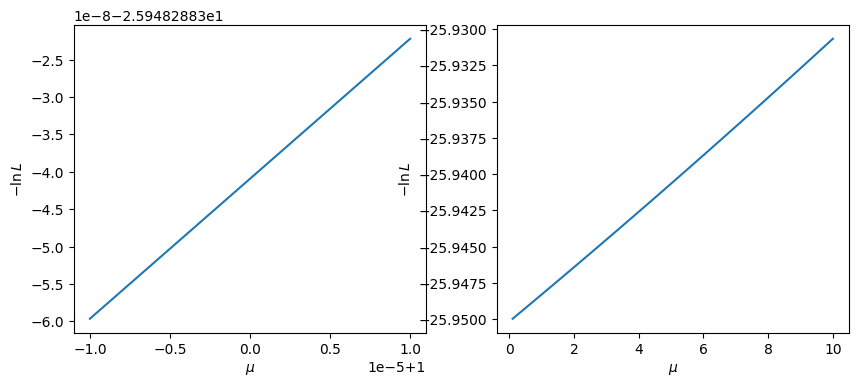

In [14]:
# first plot for the multinormal model, left plot has mu values very close to 1, right has a larger range
fig1, (ax1L,ax1R) = plt.subplots(ncols=2, figsize=(10,4))

plot_nnl_range(multinorm,np.linspace(0.99999,1.00001,100),ax1L)
plot_nnl_range(multinorm,np.linspace(0.1,10.,100),ax1R)


<Axes: xlabel='$\\mu$', ylabel='$-\\ln L$'>

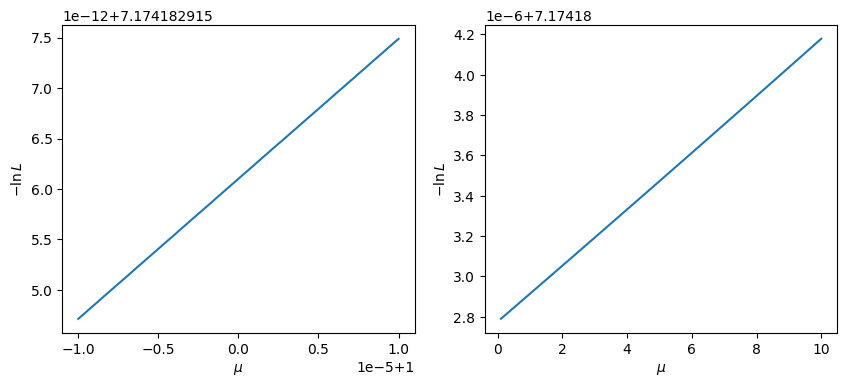

In [15]:
# do the same for the contur model, the NLL landscape is flatter
spey.set_log_level(2)
fig2, (ax2L,ax2R) = plt.subplots(ncols=2, figsize=(10,4))

plot_nnl_range(contur_model,np.linspace(0.99999,1.00001,100),ax2L)
plot_nnl_range(contur_model,np.linspace(0.1,10.,100),ax2R)



In [26]:
multinorm.backend._main_model._pdf(pars=[0.0]).cov(val=[0.0])

array([[1.69049994e-07, 3.41845046e-08, 1.09669171e-09],
       [3.41845046e-08, 1.60900800e-08, 3.20895254e-10],
       [1.09669171e-09, 3.20895254e-10, 1.94099675e-11]])

## Investigating spey's model combiner


In [30]:
# data copied from contur histogram
s = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
b = np.array([0.5182588, 0.07834322, 0.356363, 0.08658745, 0.07556074, 0.3293249,
              0.3609728, 0.2512425, 0.1550958, 0.09602748, 0.0582145, 0.03103152,
              0.01372487, 0.00519018, 0.00085627])
d = np.array([0.5100341, 0.09334923, 0.4335068, 0.09532187, 0.08699488, 0.33711,
              0.3715124, 0.3026671, 0.1698501, 0.08211375, 0.05865921, 0.03999472,
              0.01266759, 0.00832014, 0.00137639])

B1 = np.array([
    [2.99405172e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 3.62230683e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 3.79824197e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.43746503e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.95110432e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.24589603e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.25984268e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.07263409e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.61230443e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.70780145e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.80661706e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.54398427e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.63045386e-06, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.42989317e-05, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.12642962e-04]
])



In [32]:
no_signal = spey.get_backend('default_pdf.multivariate_normal')(
    signal_yields = s,
    background_yields  =b,
    data = d,
    covariance_matrix = B1
)

In [33]:
no_signal.exclusion_confidence_level(calculator='chi_square')

[0.0]

In [35]:
# build a combined model 
from spey.combiner.uncorrelated_statistics_combiner import UnCorrStatisticsCombiner

combined = UnCorrStatisticsCombiner(*[no_signal])

In [37]:
# try to calculate CLs
combined.exclusion_confidence_level(calculator='chi_square')

LinAlgError: Singular matrix

In [38]:
inv_B1 = np.linalg.inv(B1)